In [ ]:
!pip install tensorflow==2.2.0
!pip install gpflow
!pip install gast
!pip install observations

In [ ]:
from typing import Tuple, Optional
import tempfile
import pathlib

import datetime
import io
import matplotlib.pyplot as plt

import numpy as np
import tensorflow as tf
import gpflow

import matplotlib.pyplot as plt

from gpflow.config import default_float, default_jitter
from gpflow.ci_utils import ci_niter
from gpflow.utilities import to_default_float
from gpflow.base import TensorLike
from gpflow import covariances as cov
from gpflow import kullback_leiblers as kl
from gpflow.covariances import Kuu
from gpflow.covariances import Kuf

from __future__ import absolute_import
from __future__ import division
from __future__ import print_function

import csv
import numpy as np
import os
import sys
from shutil import copyfile, rmtree
import pickle

import observations

import warnings

warnings.filterwarnings("ignore")
sys.path.insert(0,'./VFF/')

import VFF_IV

helloworld


Make `tensorboard` work inside notebook:

In [ ]:
output_logdir = "/tmp/tensorboard"

!rm -rf "{output_logdir}"
!mkdir "{output_logdir}"

%load_ext tensorboard
%matplotlib inline


def enumerated_logdir(_logdir_id: int = [0]):
    logdir = pathlib.Path(output_logdir, str(_logdir_id[0]))
    _logdir_id[0] += 1
    return str(logdir)

Set up random seeds and default float for `gpflow` tensors:

In [ ]:
gpflow.config.set_default_float(np.float64)
np.random.seed(0)
tf.random.set_seed(0)

## Loading the snelson dataset

In [ ]:
'''
  This code was copied from https://github.com/edwardlib/observations/blob/master/observations/snelson1d.py
  on 01/05/2020
'''

from observations.util import maybe_download_and_extract


def snelson1d(path):
  """Load Edward Snelson's 1d regression data set [@snelson2006fitc].
  It contains 200 examples of a few oscillations of an example function. It has
  seen extensive use as a toy dataset for illustrating qualitative behaviour of
  Gaussian process approximations.
  Args:
    path: str.
      Path to directory which either stores file or otherwise file will be
      downloaded and extracted there. Filenames are `snelson_train_*`.
  Returns:
    Tuple of two np.darray `inputs` and `outputs` with 200 rows and 1 column.
  """
  path = os.path.expanduser(path)
  inputs_path = os.path.join(path, 'snelson_train_inputs')
  outputs_path = os.path.join(path, 'snelson_train_outputs')

  # Contains all source as well. We just need the data.
  url = 'http://www.gatsby.ucl.ac.uk/~snelson/SPGP_dist.zip'

  if not (os.path.exists(inputs_path) and os.path.exists(outputs_path)):
    maybe_download_and_extract(path, url)

    # Copy the required data
    copyfile(os.path.join(path, "SPGP_dist", "train_inputs"), inputs_path)
    copyfile(os.path.join(path, "SPGP_dist", "train_outputs"), outputs_path)

    # Clean up everything else
    rmtree(os.path.join(path, "SPGP_dist"))
    os.remove(os.path.join(path, "SPGP_dist.zip"))

  X = np.loadtxt(os.path.join(inputs_path))[:, None]
  Y = np.loadtxt(os.path.join(outputs_path))[:, None]

  return X, Y

In [ ]:
X, Y = snelson1d(".")
num_train_data = X.shape[0]

Working with TensorFlow Datasets is an efficient way to rapidly shuffle, iterate, and batch from data. For `prefetch` size we use `tf.data.experimental.AUTOTUNE` as recommended by TensorFlow [guidelines](https://www.tensorflow.org/guide/data_performance).

In [ ]:
train_dataset = tf.data.Dataset.from_tensor_slices((X, Y))

batch_size = 32
num_features = 10
prefetch_size = tf.data.experimental.AUTOTUNE
shuffle_buffer_size = num_train_data // 2
num_batches_per_epoch = num_train_data // batch_size

original_train_dataset = train_dataset
train_dataset = (
    train_dataset.repeat()
    .prefetch(prefetch_size)
    .shuffle(buffer_size=shuffle_buffer_size)
    .batch(batch_size)
)

print(f"prefetch_size={prefetch_size}")
print(f"shuffle_buffer_size={shuffle_buffer_size}")
print(f"num_batches_per_epoch={num_batches_per_epoch}")

prefetch_size=-1
shuffle_buffer_size=100
num_batches_per_epoch=6


In [ ]:
from gpflow.conditionals import conditional

def plot(Xtest, models):

  for (mean, std, meanColour, stdColour) in models:
    plt.plot(Xtest, mean, color=meanColour)

    plt.plot(Xtest, mean + std, color=stdColour)
    plt.plot(Xtest, mean - std, color=stdColour)
    plt.fill_between(np.squeeze(Xtest), np.squeeze(mean + std), np.squeeze(mean - std), color=stdColour, alpha=0.2)
  

  plt.scatter(X, Y, s=15)

  plt.show()



## Define a GP model

In GPflow 2.0, we use `tf.Module` (or the very thin `gpflow.base.Module` wrapper) to build all our models, as well as their components (kernels, likelihoods, parameters, and so on).

### 1D Random Variational Fourier Feature Class

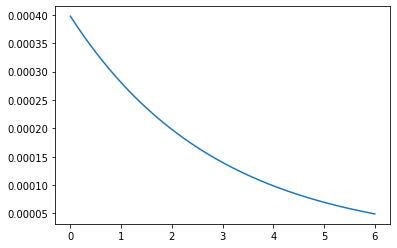

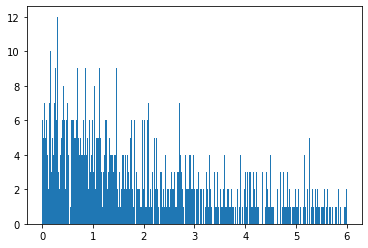

In [ ]:
#from scipy.stats import rv_continuous

# b = 6
# a = 0
# intervalLen = b - a
# resolution = 1e-3

# x = np.arange(0, intervalLen, resolution)

# var = 0.51
# l = 2.87
# mu = var * np.exp(-x/l)

# mu = mu / tf.reduce_sum(mu) # (intervalLen * tf.reduce_sum(mu)/len(x) ) / 10.0
# class matern12PowerSpectrum(rv_continuous):
#   def __init__(self, mu, a, b, resolution):
#     rv_continuous.__init__(self, a=a, b=b)
#     self.cumulativeMu = np.cumsum(mu)
#     self.res = resolution
#     self.max=-5

#   def _cdf(self, x):
#     x = int(x / self.res)
#     return self.cumulativeMu[x]

# p = matern12PowerSpectrum(mu, a, b, resolution)

In [ ]:
# class RVFF_1D(gpflow.inducing_variables.InducingVariables):
#     def __init__(self, a, b, M):
#         self.length = M
#         # [a, b] defining the interval of the Fourier representation:
#         self.a = gpflow.Parameter(a, dtype=gpflow.default_float())
#         self.b = gpflow.Parameter(b, dtype=gpflow.default_float())

#         self.phis = gpflow.Parameter(np.random.uniform(0, 2 * np.pi, size=M))
#         self.omegas = gpflow.Parameter(np.random.uniform(0, 0.5 * M, size=M))
#         # self.omegas = gpflow.Parameter( p.rvs( size=M ) + default_jitter() )

#     def __len__(self):
#         """ number of inducing variables (defines dimensionality of q(u)) """ 
#         return self.length  # M sine components

In [ ]:
# @cov.Kuu.register(RVFF_1D, gpflow.kernels.Matern12)
# def Kuu_matern12_RVFF_1D(inducing_variable, kernel, jitter=None):
#     a, b, omegas, phis = (lambda u: (u.a, u.b, u.omegas, u.phis))(inducing_variable)
    
#     lambda_ = 1.0 / kernel.lengthscales
    
#     def innerProduct( intervalLen, omegas, phis, kernelVar, lambda_):
#       angle1 = intervalLen * ( omegas[:, None] - omegas[None, :] ) + omegas[:, None] * phis[:, None] - omegas[None, :] * phis[None, :]
#       angle2 = intervalLen * ( omegas[:, None] + omegas[None, :] ) + omegas[:, None] * phis[:, None] + omegas[None, :] * phis[None, :]
#       angle3 = omegas[:, None] * phis[:, None] - omegas[None, :] * phis[None, :]
#       angle4 = omegas[:, None] * phis[:, None] + omegas[None, :] * phis[None, :]
#       angle5 = omegas * ( 2 * intervalLen + phis[:, None] + phis[None, :] )
#       angle6 = omegas * (phis[:, None] + phis[None, :])

#       denom1 = tf.Variable(omegas[:, None] - omegas[None, :])
#       denom2 = tf.Variable(omegas[:, None] + omegas[None, :])
#       denom3 = tf.Variable(2 * omegas)

#       denom1 = tf.where(denom1 == 0, 1.0, denom1)
#       denom2 = tf.where(denom2 == 0, 1.0, denom2)
#       denom3 = tf.where(denom3 == 0, 1.0, denom3)
      
#       coeff1 = ( omegas[:, None] * omegas[None, :] + lambda_ * lambda_ ) / denom1 
#       coeff2 = ( omegas[:, None] * omegas[None, :] - lambda_ * lambda_ ) / denom2 #( omegas[:, None] + omegas[None, :] )
#       coeff3 = ( omegas * omegas - lambda_ * lambda_ ) / denom3
#       coeff4 = -coeff3
#       coeff5 = lambda_ * lambda_ + omegas * omegas

#       denom = 4  * kernelVar * lambda_

#       firstTerm = ( coeff1 * tf.sin( angle1 ) +
#                     coeff2 * tf.sin( angle2 ) -
#                     lambda_ * tf.cos( angle2 ) +
#                     lambda_ * tf.cos( angle1 ) -
#                     coeff1 * tf.sin( angle3 ) -
#                     coeff2 * tf.sin( angle4 ) +
#                     lambda_ * tf.cos( angle4 ) -
#                     lambda_ * tf.cos( angle3 ) ) / denom

#       firstTermForEqualOmegas = ( ( omegas * omegas + lambda_ * lambda_ ) * tf.cos(omegas * (phis[:, None] - phis[None, :]) ) * intervalLen + 
#                                 coeff3 * tf.sin( angle5 ) -
#                                 ( lambda_ * tf.cos( angle5 ) ) -
#                                 ( coeff3 * tf.sin( angle6 ) ) +
#                                 lambda_ * tf.cos( angle6 ) ) / denom

#       firstTermForZeroOmegas = tf.reshape(tf.Variable(intervalLen * lambda_ / kernelVar / 2), shape=(-1))

#       firstTerm = tf.where( denom1 == 1.0, firstTermForEqualOmegas, firstTerm )
#       firstTerm = tf.where( denom3 == 1.0, 0.0, firstTerm )
#       firstTerm = tf.where( denom2 == 1.0, firstTermForZeroOmegas, firstTerm )

#       secondTermfactors = tf.where( denom3 != 1.0, tf.sin( omegas * phis ), tf.sin( phis ) )

#       secondTerm = secondTermfactors[:, None] * secondTermfactors[None, :] / kernelVar

#       res = firstTerm + secondTerm
#       res = 0.5 * (res + tf.transpose(res))

#       if jitter != None:
#         res = res + tf.cast(tf.linalg.diag( jitter * tf.ones( res.shape[0] ) ), default_float())
    
#       return res

#     return innerProduct( b - a, omegas, phis, kernel.variance, lambda_ )

# @cov.Kuf.register(RVFF_1D, gpflow.kernels.Matern12, TensorLike)
# def Kuf_matern12_RVFF_1D(inducing_variable, kernel, X):
#     X = tf.squeeze(X, axis=1)
#     a, omegas, phis = (lambda u: (u.a, u.omegas, u.phis))(inducing_variable)       
    
#     nonZeroOmegas = tf.sin( omegas[:, None] * ( X[None, :] - a + phis[:, None]) )
#     phis = tf.tile(tf.reshape(phis, (-1,1)), [1, len(X)])
#     omegas = tf.tile(tf.reshape(omegas, (-1,1)), [1, len(X)])
#     zeroOmegas = tf.sin( phis )

#     res = tf.where( omegas != 0, nonZeroOmegas, zeroOmegas )
    
#     return res

#Model Definition:

###We use exact inference first

0
kernel lengthscale: 0.50
kernel variance: 0.50
Exact model log p(y): -216.95


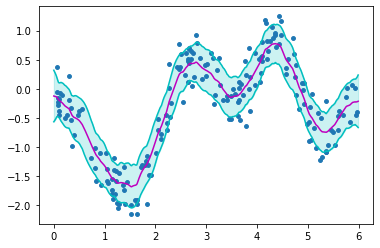

100
kernel lengthscale: 0.89
kernel variance: 0.35
Exact model log p(y): -155.90


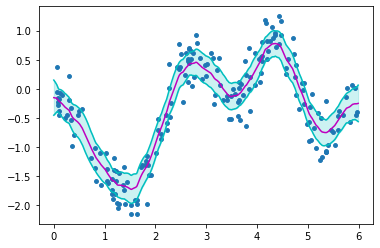

200
kernel lengthscale: 1.20
kernel variance: 0.39
Exact model log p(y): -100.44


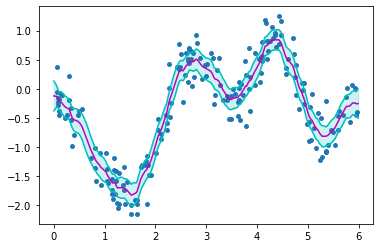

300
kernel lengthscale: 1.42
kernel variance: 0.44
Exact model log p(y): -73.39


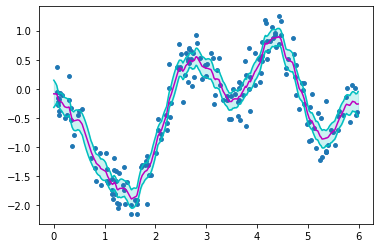

400
kernel lengthscale: 1.55
kernel variance: 0.51
Exact model log p(y): -68.61


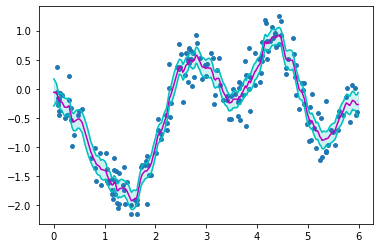

500
kernel lengthscale: 1.62
kernel variance: 0.54
Exact model log p(y): -68.32


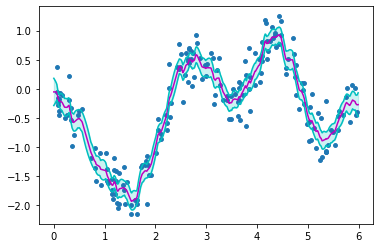

600
kernel lengthscale: 1.67
kernel variance: 0.56
Exact model log p(y): -68.31


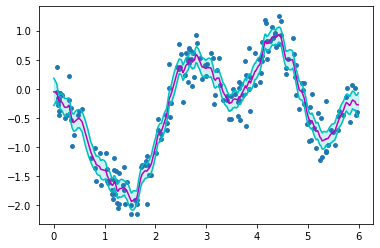

700
kernel lengthscale: 1.71
kernel variance: 0.57
Exact model log p(y): -68.31


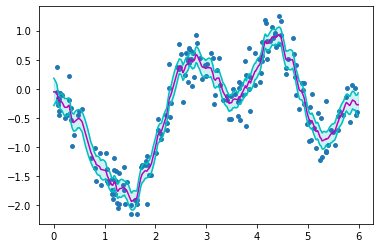

800
kernel lengthscale: 1.73
kernel variance: 0.58
Exact model log p(y): -68.31


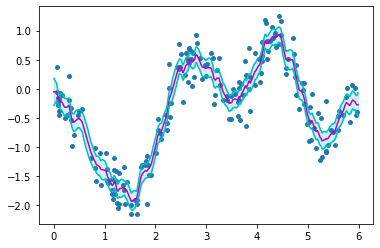

900
kernel lengthscale: 1.75
kernel variance: 0.58
Exact model log p(y): -68.31


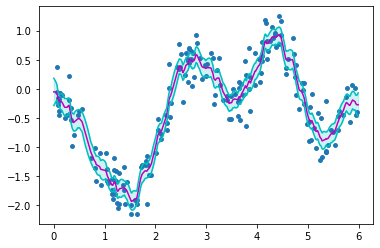

Exact model log p(y): -68.31


In [ ]:

kernel = gpflow.kernels.Matern12(variance=0.5, lengthscales=0.5)
likelihood = gpflow.likelihoods.Gaussian()

exactModel = gpflow.models.GPR( (X, Y), kernel )

gpflow.utilities.set_trainable(kernel.lengthscales, True)
gpflow.utilities.set_trainable(kernel.variance, True)

optimizer = tf.optimizers.Adam(learning_rate=0.01)

@tf.function
def loss_closure():
  return -exactModel.log_marginal_likelihood()

Xtest = np.arange(0.0, 6.0, 0.01).reshape(-1, 1)

for i in range(1000):
  if i % 100 == 0:
    print(i)
    print("kernel lengthscale: %2.2f" % kernel.lengthscales.read_value())
    print("kernel variance: %2.2f" % kernel.variance.read_value())
    print("Exact model log p(y): %2.2f" % exactModel.log_marginal_likelihood() )

    mean, std = exactModel.predict_f(Xtest, False, False)
    std = tf.sqrt(std)
    plot(Xtest, [(mean, std, 'm', 'c')])

  optimizer.minimize( loss=loss_closure, var_list=exactModel.trainable_variables )

print("Exact model log p(y): %2.2f" % exactModel.log_marginal_likelihood() )

###We now use approximate inference with Random Variational Fourier Features

tf.Tensor(
[1.13194816e-02 9.11608449e-02 4.23818917e-01 2.45417853e+00
 2.72930837e+00 7.38140761e+00 1.19908911e+01 1.51582701e+01
 1.60571632e+01 1.89614327e+01 2.91414030e+01 2.92207323e+01
 3.12149244e+01 3.75840742e+01 5.59851264e+01 6.05735283e+01
 1.07773395e+02 1.33144366e+02 1.50064448e+02 1.62524479e+02
 1.70802909e+02 2.30583379e+02 2.36074882e+02 2.43171307e+02
 2.57755952e+02 2.90493217e+02 3.03089534e+02 3.11852303e+02
 3.40635625e+02 3.45372455e+02 3.70833708e+02 3.89314970e+02
 4.39853293e+02 4.78131049e+02 5.08023072e+02 5.14688667e+02
 6.14391077e+02 7.04030447e+02 7.41807045e+02 8.02662309e+02
 8.35876430e+02 9.57108189e+02 1.03351719e+03 1.09119273e+03
 1.16317401e+03 1.22933917e+03 1.28777461e+03 1.36694598e+03
 1.56901993e+03 1.60072102e+03 1.65135859e+03 1.73865568e+03
 1.79809870e+03 1.81135471e+03 1.97309464e+03 2.02525978e+03
 2.09502331e+03 2.17176460e+03 2.29218006e+03 2.45640367e+03
 2.56294731e+03 2.66415091e+03 2.95983264e+03 3.39215852e+03
 3.90084317e+

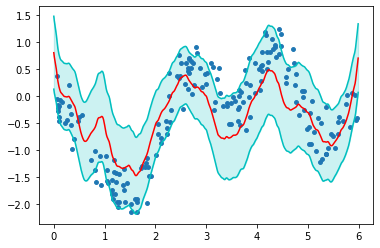

Iteration: 100
kernel lengthscale: 0.53
kernel variance: 0.49
ELBO: -181.84


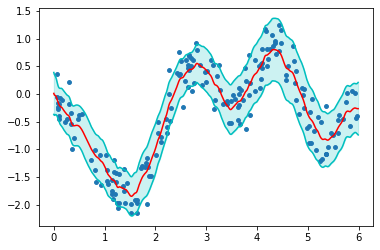

Iteration: 200
kernel lengthscale: 0.52
kernel variance: 0.22
ELBO: -139.88


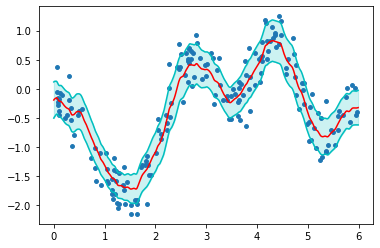

Iteration: 300
kernel lengthscale: 0.58
kernel variance: 0.13
ELBO: -112.00


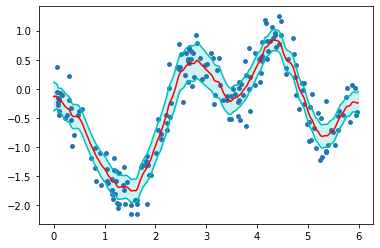

Iteration: 400
kernel lengthscale: 0.56
kernel variance: 0.11
ELBO: -110.76


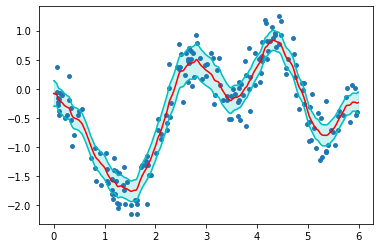

Iteration: 500
kernel lengthscale: 0.55
kernel variance: 0.10
ELBO: -111.49


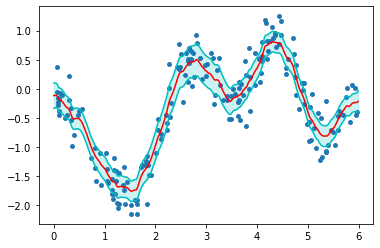

Iteration: 600
kernel lengthscale: 0.54
kernel variance: 0.10
ELBO: -113.15


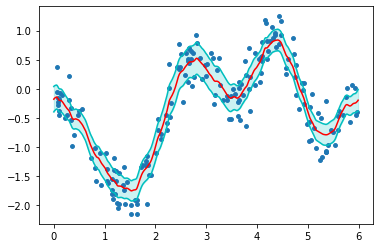

Iteration: 700
kernel lengthscale: 0.55
kernel variance: 0.10
ELBO: -111.05


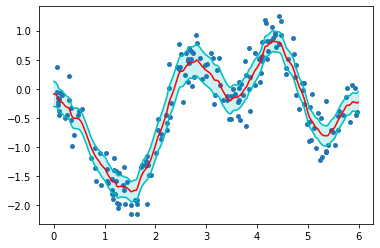

Iteration: 800
kernel lengthscale: 0.55
kernel variance: 0.10
ELBO: -111.00


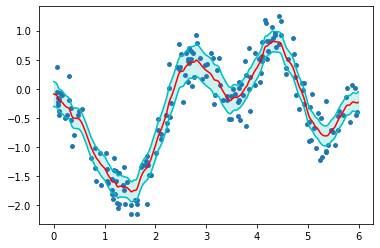

Iteration: 900
kernel lengthscale: 0.55
kernel variance: 0.10
ELBO: -110.79


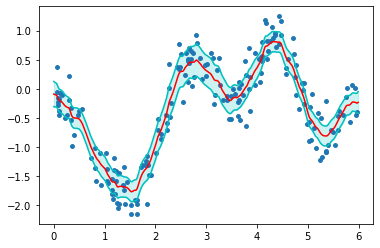

Iteration: 1000
kernel lengthscale: 0.55
kernel variance: 0.10
ELBO: -110.47


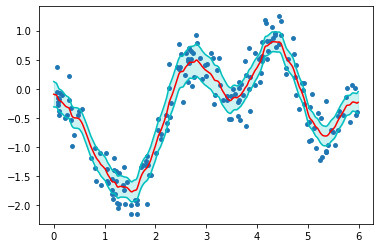

Iteration: 1100
kernel lengthscale: 0.56
kernel variance: 0.10
ELBO: -109.91


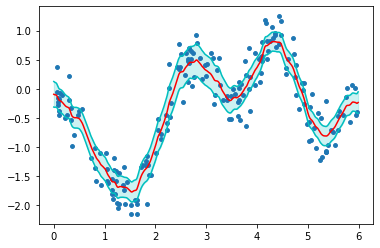

KeyboardInterrupt: ignored

In [ ]:
tf.config.experimental_run_functions_eagerly(True)

M = 100
inducing_variable = RVFF_1D( a=0, b=6, M=M )

kernel2 = gpflow.kernels.Matern12(variance=1.0, lengthscales=0.7)

model = gpflow.models.SGPR(
    (X, Y), kernel=kernel2, inducing_variable=inducing_variable
)

optimizer = tf.optimizers.Adam(learning_rate=0.01)

gpflow.set_trainable(kernel2.variance, True)
gpflow.set_trainable(kernel2.lengthscales, True)
gpflow.set_trainable(model.likelihood, True)
gpflow.set_trainable(model.inducing_variable.a, False)
gpflow.set_trainable(model.inducing_variable.b, False)
gpflow.set_trainable(model.inducing_variable.phis, True)
gpflow.set_trainable(model.inducing_variable.omegas, True)

@tf.function
def loss_closure():
  return -model.elbo()

# Compute the gradients for a list of variables.
# with tf.GradientTape() as tape:
#   loss = loss_closure()
# var_list = model.trainable_parameters
# grads = tape.gradient(loss, var_list)

# print(grads)

# Ask the optimizer to apply the processed gradients.
# optimizer.apply_gradients(zip(grads, var_list))

print(tf.linalg.eigh(Kuu(inducing_variable, model.kernel))[0])
print('='*100)

print(tf.sort(inducing_variable.omegas))
print('='*100)

initialOmegas = inducing_variable.omegas.read_value()

for i in range(3000):
  if i % 100 == 0:
    print("Iteration: %2d" % i)
    print("kernel lengthscale: %2.2f" % kernel2.lengthscales.read_value())
    print("kernel variance: %2.2f" % kernel2.variance.read_value())
    print("ELBO: %2.2f" % model.elbo() )

    mean, std = model.predict_f(Xtest, False, False)
    std = tf.sqrt(std)
    plot(Xtest, [(mean, std, 'r', 'c')])

  optimizer.minimize( loss=loss_closure, var_list=model.trainable_variables )

print( "Variational Model ELBO is %3.2f" % model.elbo() )

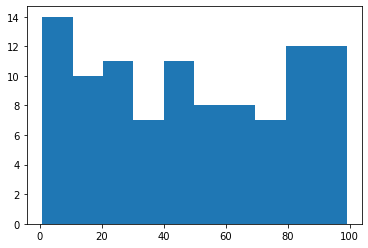

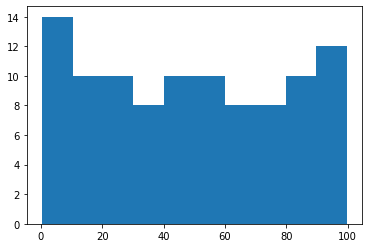

In [ ]:
b = 10

plt.hist(initialOmegas, bins=b)
plt.show()

plt.hist(inducing_variable.omegas.read_value(), bins=b)
plt.show()

#Testing

###Plotting a posterior sample on top of the scatter plot of the data:

In [ ]:
with open('./model', 'wb') as fp:
    pickle.dump(model.trainable_parameters, fp)
    pickle.dump(inducing_variable.omegas, fp)
    pickle.dump(inducing_variable.phis, fp)
    pickle.dump(model.likelihood.variance, fp)

In [ ]:
with open('./model', 'rb') as fp:
    param_dict = pickle.load(fp)
    omegas = pickle.load(fp)
    phis = pickle.load(fp)
    likelihoodVariance = pickle.load(fp)

inducing_variable = RVFF_1D( a=0, b=6, M=M )
inducing_variable.omegas = omegas
inducing_variable.phis = phis

model = gpflow.models.SGPR((X, Y), kernel=kernel, inducing_variable=inducing_variable)
model.likelihood.variance = likelihoodVariance

gpflow.utilities.set_trainable(kernel.lengthscales, False)
gpflow.utilities.set_trainable(kernel.variance, False)
gpflow.utilities.set_trainable(inducing_variable.a, False)
gpflow.utilities.set_trainable(inducing_variable.b, False)

if len(model.trainable_parameters) == len(param_dict):
  for i in range(len(model.trainable_parameters)):
    model.trainable_parameters[i].assign(param_dict[i])

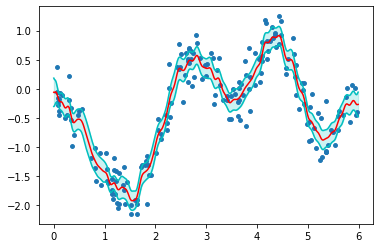

ELBO of SGPR model is -79.21
log( p( Y | θ ) ) of exact GP is -68.31


In [ ]:
mean, std = model.predict_f(Xtest, False, False)
std = tf.sqrt(std)
plot(Xtest, [(mean, std, 'r', 'c')])

print("ELBO of SGPR model is %4.2f" % model.elbo().numpy())
print("log( p( Y | θ ) ) of exact GP is %4.2f" % exactModel.log_marginal_likelihood().numpy())

Testing whether the model is the equivalent to Variational Fourier Features when the frequencies and phases are set manually to correspond to multiples of the base frequency, and not optimised as variational parameters. 

Instructions for updating:
Do not call `graph_parents`.


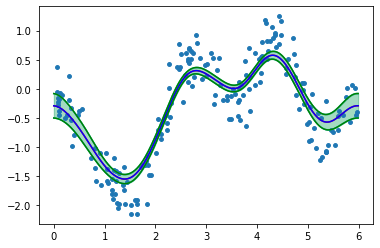

If you can only see one mean function and one error bar, VFF and RVFF perfectly coincide.
RVFF model ELBO is -217.68
VFF model ELBO is -217.68
Test passed!


In [ ]:
def testFeatureequivalence(tol):
  VFFlength = 10
  RVFFlength = 2 * VFFlength - 1

  VFFinducingVar = VFF_IV.FourierFeatures1D(0, 6, VFFlength)
  VFFmodel = gpflow.models.SGPR((X, Y), kernel2, VFFinducingVar)

  RVFFinducingVar = RVFF_1D(0, 6, RVFFlength)

  RVFFfrequencies = tf.concat( ( VFFinducingVar.omegas, tf.reshape( tf.gather( VFFinducingVar.omegas, tf.where( VFFinducingVar.omegas != 0.0 ) ), [-1] ) ), axis=0 )
  RVFFphases = tf.concat( ( np.pi / ( 2 * VFFinducingVar.omegas[1:VFFlength] ), tf.zeros(RVFFlength - VFFlength, dtype=default_float()) ), axis=0 )
  RVFFphases = tf.concat( ( tf.constant([ np.pi / 2 ], dtype=default_float()), RVFFphases ), axis=0 )

  RVFFinducingVar.omegas.assign( RVFFfrequencies )
  RVFFinducingVar.phis.assign( RVFFphases )

  RVFFmodel = gpflow.models.SGPR((X, Y), kernel2, RVFFinducingVar)
    
  meanVFF, covVFF = VFFmodel.predict_f(Xtest, True, False)
  meanRVFF, covRVFF = RVFFmodel.predict_f(Xtest, True, False)
  
  plot(Xtest, [(meanVFF, tf.transpose(tf.linalg.diag_part(covVFF)), 'r', 'c'), (meanRVFF, tf.transpose(tf.linalg.diag_part(covRVFF)), 'b', 'g')])
  print("If you can only see one mean function and one error bar, VFF and RVFF perfectly coincide.")

  print("RVFF model ELBO is %2.2f" % RVFFmodel.elbo())
  print("VFF model ELBO is %2.2f" % VFFmodel.elbo())

  return tf.math.reduce_sum(tf.math.abs(covRVFF-covVFF)) < tol and tf.math.reduce_sum(tf.math.abs(meanRVFF-meanVFF)) < tol

str = "Test passed!" if testFeatureequivalence(10e-2) else "Test failed."
print(str)

Testing whether $q(u) = p(u)$ when we fix q_sqrt = cholesky($K_{uu}$)

In [ ]:
kernel = gpflow.kernels.Matern12(variance=5, lengthscales=10.0)
likelihood = gpflow.likelihoods.Gaussian()

inducing_variable = RVFF_1D( a=0, b=6, M=M )

def testPriorEqualsPosterior():
  model = gpflow.models.SVGP(
      kernel=kernel, likelihood=likelihood, inducing_variable=inducing_variable
  )
  q_sqrt = tf.linalg.cholesky( Kuu_matern12_RVFF_1D(model.inducing_variable, model.kernel) )

  return model.prior_kl()

print( "KL[ q(u) | p(u) ] = %2.3f" % testPriorEqualsPosterior() )

KL[ q(u) | p(u) ] = 0.000


Testing whether $K_{uu}$ is computed correctly with Monte-Carlo integration:

In [ ]:
def grid_search_integrate(f, bound1, bound2, numOfSamples):
  samples = tf.range(bound1, bound2, ( bound2 - bound1 ) / float(numOfSamples))
  V = tf.math.reduce_prod( bound2 - bound1 )

  return V * tf.math.reduce_sum( f( samples ) ) / numOfSamples

def mattern_half_inner_product_integrand(f, g, df, dg, lambda_):
  def evaluate_on(x):
    return ( lambda_ * f(x) + df(x) ) * ( lambda_ * g(x) + dg(x) )
  return evaluate_on

def grid_search_mattern_half_inner_prod( sigma, lambda_, a, b, omega1, phi1, omega2, phi2 ):
  f = sin(omega1, a, phi1)
  g = sin(omega2, a, phi2)
  
  df = dsin(omega1, a, phi1)
  dg = dsin(omega2, a, phi2)

  integral = grid_search_integrate(
      mattern_half_inner_product_integrand(f, g, df, dg, lambda_),
      a,
      b,
      10e6
  )

  term1 = integral / ( 2 * lambda_ * sigma * sigma )
  term2 = f(a) * g(a) / (sigma * sigma)

  return term1 + term2

def sin( omega, a, phi ):
  def compute_sin(x):
    return tf.sin( omega * ( x - a + phi ) )
  return compute_sin

def dsin( omega, a, phi ):
  def compute_dsin(x):
    return omega * tf.cos( omega * ( x - a + phi ) )
  return compute_dsin

def test_Kuu_evaluation(inducing_variable, kernel, tol):
  analyticKuu = gpflow.covariances.Kuu(inducing_variable, kernel)
  numericalKuu = np.empty((len(inducing_variable), len(inducing_variable)))

  a, b, omegas, phis = (lambda u: (u.a, u.b, u.omegas, u.phis)) (inducing_variable)  
  lambda_, sigma = (lambda k: (1/k.lengthscales, k.variance))(kernel)

  for i in range(len(inducing_variable)):
    for j in range(len(inducing_variable)):
      numericalKuu[i, j] = grid_search_mattern_half_inner_prod(sigma, lambda_, a, b, omegas[i], phis[i], omegas[j], phis[j])

  print(analyticKuu)
  print(numericalKuu)

  return True if tf.reduce_all( abs(analyticKuu - numericalKuu) < tol ) else False

str = "Test passed!" if test_Kuu_evaluation(RVFF_1D(0, 6, 2), gpflow.kernels.Matern12(), 10e-3) else "Test failed."
print(str)

tf.Tensor(
[[ 3.03954166 -0.02848607]
 [-0.02848607  3.40341883]], shape=(2, 2), dtype=float64)
[[ 3.03954172 -0.02848579]
 [-0.02848579  3.4034188 ]]
Test passed!


Testing whether the predictive covariance $K_{ff}$ is positive semidefinite.

In [ ]:
def is_psd(matrix, tol):
  return tf.reduce_all(tf.linalg.eigh(matrix)[0] > tol)

def test_predictive_cov_is_psd(model):
  Xtest = np.arange(0, 6, 0.05).reshape(-1, 1)
  predictive_cov = tf.squeeze( model.predict_f(X, True, False)[1] )
  return is_psd(predictive_cov, -1e-1)

str = "True" if test_predictive_cov_is_psd(model) else "False"
print( "predictive_cov is psd: " + str )

predictive_cov is psd: True


# Feature comparison with Variational Fourier Features

Current number of basis functions:  11

====================== TRAINING NEW MODEL ==========================

Iteration  0
Kernel lengthscale: 0.70
Kernel variance: 1.00
Model likelihood variance: 1.00
Model ELBO: -229.80


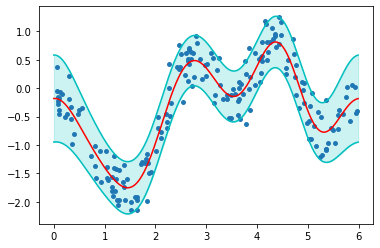

Iteration 100
Kernel lengthscale: 1.09
Kernel variance: 0.50
Model likelihood variance: 0.48
Model ELBO: -167.29


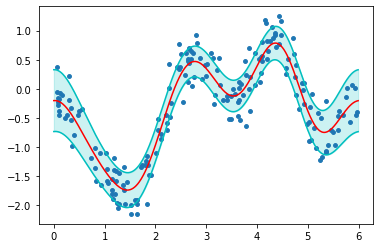

Iteration 200
Kernel lengthscale: 0.99
Kernel variance: 0.24
Model likelihood variance: 0.21
Model ELBO: -117.83


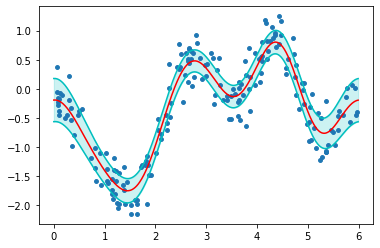

Iteration 300
Kernel lengthscale: 0.84
Kernel variance: 0.15
Model likelihood variance: 0.13
Model ELBO: -101.72


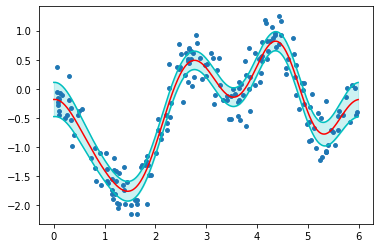

Iteration 400
Kernel lengthscale: 0.81
Kernel variance: 0.13
Model likelihood variance: 0.11
Model ELBO: -100.74


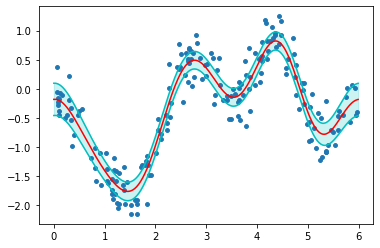

Iteration 500
Kernel lengthscale: 0.81
Kernel variance: 0.13
Model likelihood variance: 0.11
Model ELBO: -100.74


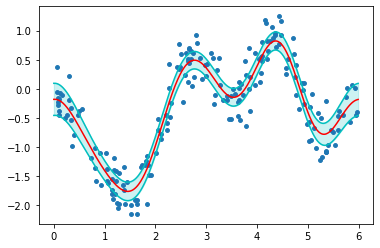

Final ELBO is -100.74

====================== TRAINING NEW MODEL ==========================

Iteration  0
Kernel lengthscale: 0.70
Kernel variance: 1.00
Model likelihood variance: 1.00
Model ELBO: -227.08


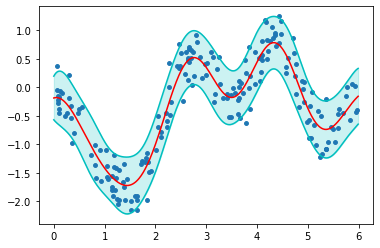

Iteration 100
Kernel lengthscale: 1.84
Kernel variance: 0.29
Model likelihood variance: 0.11
Model ELBO: -89.93


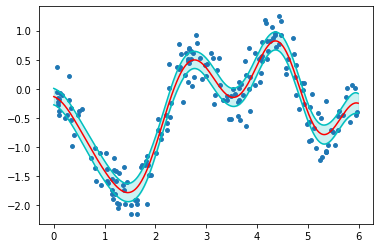

Iteration 200
Kernel lengthscale: 2.10
Kernel variance: 0.31
Model likelihood variance: 0.10
Model ELBO: -89.16


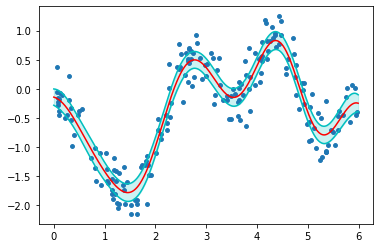

Iteration 300
Kernel lengthscale: 2.23
Kernel variance: 0.33
Model likelihood variance: 0.10
Model ELBO: -89.59


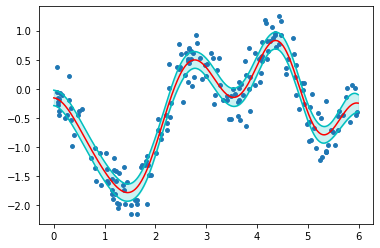

Iteration 400
Kernel lengthscale: 2.37
Kernel variance: 0.35
Model likelihood variance: 0.10
Model ELBO: -89.35


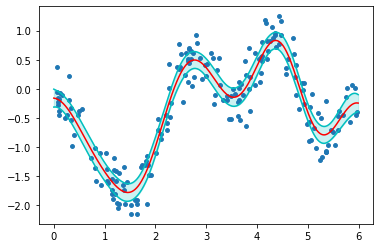

Iteration 500
Kernel lengthscale: 2.47
Kernel variance: 0.36
Model likelihood variance: 0.10
Model ELBO: -89.32


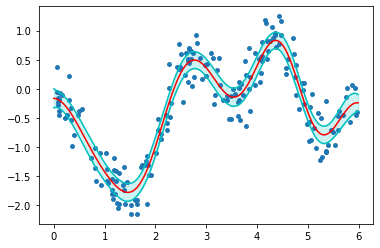

Final ELBO is -89.32
Current number of basis functions:  12

====================== TRAINING NEW MODEL ==========================

Iteration  0
Kernel lengthscale: 0.81
Kernel variance: 0.13
Model likelihood variance: 0.11
Model ELBO: -99.46


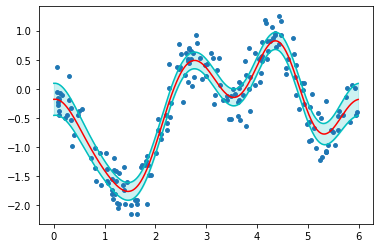

Iteration 100
Kernel lengthscale: 1.00
Kernel variance: 0.17
Model likelihood variance: 0.10
Model ELBO: -94.39


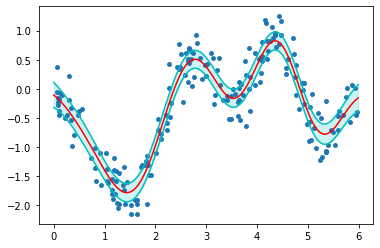

KeyboardInterrupt: ignored

In [ ]:
def getNextVFFmodel(VFFmodel, numAddedFrequencies):
  VFFlength = len(VFFmodel.inducing_variable.omegas) + numAddedFrequencies

  VFFinducingVar = VFF_IV.FourierFeatures1D(0,6, VFFlength)
  newVFFmodel = gpflow.models.SGPR((X, Y), VFFmodel.kernel, VFFinducingVar)
  newVFFmodel.likelihood = VFFmodel.likelihood

  return newVFFmodel

def getNextRVFFmodel(RVFFmodel, numAddedFrequencies):
  prevLength = len(RVFFmodel.inducing_variable)
  RVFFlength = prevLength + numAddedFrequencies

  RVFFinducingVar = RVFF_1D(a=0, b=6, M=RVFFlength)

  highestOmega = tf.math.reduce_max(RVFFmodel.inducing_variable.omegas.read_value()).numpy()
  newOmegas = tf.concat( [ RVFFmodel.inducing_variable.omegas.read_value(), np.random.uniform(0.5 * prevLength, 0.5 * RVFFlength, numAddedFrequencies) ], axis=0 )
  newPhis = tf.concat( [ RVFFmodel.inducing_variable.phis.read_value(), np.random.uniform(0, 2 * np.pi, numAddedFrequencies) ], axis=0 )

  RVFFinducingVar.omegas.assign( newOmegas )
  RVFFinducingVar.phis.assign( newPhis )

  gpflow.set_trainable(RVFFinducingVar.a, False)
  gpflow.set_trainable(RVFFinducingVar.b, False)

  newRVFFmodel = gpflow.models.SGPR((X, Y), RVFFmodel.kernel, RVFFinducingVar)
  newRVFFmodel.likelihood = RVFFmodel.likelihood

  RVFFmodel.inducing_variable = RVFFinducingVar

  return RVFFmodel

def getModels(numBasisFunctions):

  if numBasisFunctions % 2 != 1:
    return

  kernel1 = gpflow.kernels.Matern12(variance=1.0, lengthscales=0.7)
  # kernel2 = gpflow.kernels.Matern12(variance=1.0, lengthscales=0.7)
  kernel3 = gpflow.kernels.Matern12(variance=1.0, lengthscales=0.7)

  # ==============================================================
  # VFF model setup:
  VFFlength = int(( numBasisFunctions + 1 ) / 2)
  VFFinducingVar = VFF_IV.FourierFeatures1D(0, 6, VFFlength)
  VFFmodel = gpflow.models.SGPR((X, Y), kernel1, VFFinducingVar)
  # ==============================================================

  # ==============================================================
  # RVFF model setup, with orthogonal initial basis functions
  RVFFlength = numBasisFunctions #2 * VFFlength - 1

  # RVFFfrequencies = tf.concat( ( VFFinducingVar.omegas, tf.reshape( tf.gather( VFFinducingVar.omegas, tf.where( VFFinducingVar.omegas != 0.0 ) ), [-1] ) ), axis=0 )
  # RVFFphases = tf.concat( ( np.pi / ( 2 * VFFinducingVar.omegas[1:VFFlength] ), tf.zeros(RVFFlength - VFFlength, dtype=default_float()) ), axis=0 )
  # RVFFphases = tf.concat( ( tf.constant([ np.pi / 2 ], dtype=default_float()), RVFFphases ), axis=0 )

  # RVFFinducingVar = RVFF_1D(0, 6, RVFFlength)
  # RVFFinducingVar.omegas.assign( RVFFfrequencies )
  # RVFFinducingVar.phis.assign( RVFFphases )

  # RVFFmodel = gpflow.models.SGPR((X, Y), kernel2, RVFFinducingVar)
  # ==============================================================

  # ==============================================================
  # RVFF model, with randomly initialised frequencies:
  inducing_variable = RVFF_1D( a=0, b=6, M=RVFFlength )

  RVFFmodel = gpflow.models.SGPR( (X, Y), kernel=kernel3, inducing_variable=inducing_variable )
  # ==============================================================

  # ==============================================================
  # Trainable parameters setup:
  gpflow.set_trainable(kernel1, True)
  # gpflow.set_trainable(kernel2, True)
  gpflow.set_trainable(kernel3, True)

  gpflow.set_trainable(VFFmodel.inducing_variable.a, False)
  gpflow.set_trainable(VFFmodel.inducing_variable.b, False)
  gpflow.set_trainable(VFFmodel.likelihood, True)

  gpflow.set_trainable(RVFFmodel.inducing_variable.a, False)
  gpflow.set_trainable(RVFFmodel.inducing_variable.b, False)
  gpflow.set_trainable(RVFFmodel.inducing_variable.phis, True)
  gpflow.set_trainable(RVFFmodel.inducing_variable.omegas, True)
  gpflow.set_trainable(RVFFmodel.likelihood, True)

  # gpflow.set_trainable(RVFFmodel2.inducing_variable.a, False)
  # gpflow.set_trainable(RVFFmodel2.inducing_variable.b, False)
  # gpflow.set_trainable(RVFFmodel2.inducing_variable.phis, True)
  # gpflow.set_trainable(RVFFmodel2.inducing_variable.omegas, True)
  # gpflow.set_trainable(RVFFmodel2.likelihood, True)
  # ==============================================================

  return VFFmodel, RVFFmodel

# ==============================================================
# Loss function:
@tf.function
def loss(model):
  def loss_closure():
    return -model.elbo()
  return loss_closure
# ==============================================================

optimizer = tf.optimizers.Adam(learning_rate=0.01)

def train(model, maxIterPerModel, ELBOtolerance):

  print("\n===================================================================")
  print("====================== TRAINING NEW MODEL ==========================")
  print("===================================================================\n")

  prevElbo = model.elbo() + 2 * ELBOtolerance

  for i in range(maxIterPerModel):
    if i % 100 == 0:
      elbo = model.elbo()
      print("Iteration %2d" % i)
      print("Kernel lengthscale: %2.2f" % model.kernel.lengthscales.read_value() )
      print("Kernel variance: %2.2f" % model.kernel.variance.read_value() )
      print("Model likelihood variance: %2.2f" % model.likelihood.variance.read_value() )
      print("Model ELBO: %2.2f" % elbo )

      mean, std = model.predict_f(Xtest, False, False)
      std = tf.sqrt(std)
      plot(Xtest, [(mean, std, 'r', 'c')])

      if tf.abs( prevElbo - elbo ) < ELBOtolerance:
        break

      prevElbo = elbo

    optimizer.minimize( loss=loss(model), var_list=model.trainable_variables )

  print("Final ELBO is %2.2f" % model.elbo().numpy())

  return model.elbo().numpy()

def transposeListOfLists(l):
  l = np.array(l)
  l = l.T
  return l.tolist()

numOfBasis = list(np.arange(11, 15, 1))
models = list(getModels(11))

elbos = list()
unoptimisedRVFFelbos = list()

for length in numOfBasis:
  unoptimisedRVFFelbos.append(models[1].elbo().numpy())
  currentELBOS = []
  print("Current number of basis functions: %3d" % length)
  for model in models:
    currentELBOS.append(train(model, 100000, 10e-2))
  elbos.append(currentELBOS)
  models[0] = getNextVFFmodel(models[0], 1)
  models[1] = getNextRVFFmodel(models[1], 1)


elbos = transposeListOfLists(elbos)

VFFelbos = elbos[0]
RVFFelbos = elbos[1]

plt.plot(numOfBasis, VFFelbos)
plt.plot(numOfBasis, RVFFelbos)
plt.plot(numOfBasis, unoptimisedRVFFelbos)

plt.show()

In [ ]:
print(elbos[0])
print("==============================")
print(elbos[1])
print("==============================")
print(unoptimisedRVFFelbos)

In [ ]:
# elbos = transposeListOfLists(elbos)
RVFFelbos2 = elbos[0]
# plt.plot(numOfBasis, VFFelbos)
# plt.plot(numOfBasis, RVFFelbos)
plt.plot(RVFFelbos2)
plt.legend(["VFF", "RVFF with orthogonal initial basis functions","RVFF with randomised initial basis functions"])
plt.show()


VFFmodel, RVFFmodel, RVFFmodel2 = getModels(101)
print(tf.math.reduce_sum(tf.abs(Kuu(VFFmodel.inducing_variable, VFFmodel.kernel) - Kuu(RVFFmodel.inducing_variable, RVFFmodel.kernel))))
print(Kuu(VFFmodel.inducing_variable, VFFmodel.kernel).shape)
print(Kuu(RVFFmodel.inducing_variable, RVFFmodel.kernel).shape)